In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

T = 80
alpha = 0.3
beta = 2.0
pra = 0.7
prb = 0.3

ra = tfp.distributions.Bernoulli(probs=pra, dtype=tf.float32)
rb = tfp.distributions.Bernoulli(probs=prb, dtype=tf.float32)
Q = np.zeros((2, T+1), dtype=np.float32)
choices = np.zeros((T, ), dtype=np.int32)
rewards = np.zeros((T, ), dtype=np.float32)
pahist = np.zeros((T+1, ), dtype=np.float32)

for t in range(1, T):
    pa = 1. / (1 + tf.exp(-beta * (Q[0, t] - Q[1, t])))
    pahist[t+1] = pa
    a = tfp.distributions.Bernoulli(probs=pa, dtype=tf.bool).sample(1)[0]
    choices[t] = a
    if a == True:
        r = ra.sample(1)[0]
        Q[0, t+1] = Q[0, t] + alpha * (r - Q[0, t]) 
        Q[1, t+1] = Q[1, t]
    else:
        r = rb.sample(1)[0]
        Q[1, t+1] = Q[1, t] + alpha * (r - Q[1, t]) 
        Q[0, t+1] = Q[0, t]
    rewards[t] = r

2021-08-20 21:04:29.393086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-20 21:04:29.393127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-20 21:04:33.773629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-20 21:04:33.773702: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-20 21:04:33.773729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-26-3-85): /proc/driver/nvidia/version does not exist
2021-08-20 21:04:33.774071: I tensorflow/core/platform/cpu_fea

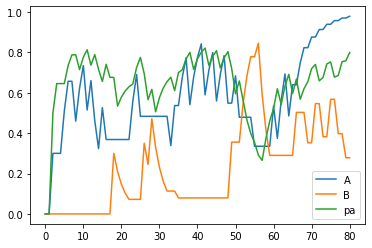

In [2]:
plt.plot(range(T+1), Q[0, :], label='A')
plt.plot(range(T+1), Q[1, :], label='B')
plt.plot(range(T+1), pahist, label='pa')
plt.legend()
plt.show()

In [50]:
alpha_prior = tfp.distributions.Beta(2.0, 2.0)
beta_prior = tfp.distributions.Gamma(2.0, 0.3333)
count = tf.Variable(0, dtype=tf.int32)

def simulate(params):
    alpha_est, beta_est = params[0], params[1]
    Qa = np.array(0.0, dtype=np.float32)
    Qb = np.array(0.0, dtype=np.float32)
    ll = tf.Variable(0.0, dtype=np.float32)

    for t in range(T):
        pa = 1. / (1 + tf.exp(-beta_est * (Qa- Qb)))
        pa = tf.clip_by_value(pa, 0.00001, 0.99999)
        ll = ll + choices[t] * tf.math.log(pa) + (1 - choices[t]) * tf.math.log(1 - pa)

        if choices[t] == 1:
            Qa = Qa + alpha_est * (rewards[t] - Qa)
        else:
            Qb = Qb + alpha_est * (rewards[t] - Qb)
    global count
    count.assign_add(1)
    tf.print('\r', count, end='')
    return ll + alpha_prior.log_prob(alpha_est) + beta_prior.log_prob(beta_est)

alpha_est = alpha_prior.sample()
beta_est = beta_prior.sample()

def sample():
  return tfp.mcmc.sample_chain(
    num_results=100,
    num_burnin_steps=500,
    current_state=np.array([alpha_est, beta_est], dtype=np.float32),
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=simulate,
                step_size=0.065,
                num_leapfrog_steps=5),
            bijector=[tfp.bijectors.Identity()]),
         num_adaptation_steps=400)
    )

In [51]:
samples, sampler_stat = sample()

 4

/home/ubuntu/.cache/pypoetry/virtualenvs/behavior-data-computation-modeling-for-pyt-shJiIBXb-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


 6002

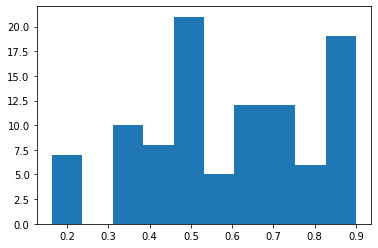

In [56]:
plt.hist(samples.numpy()[:, 0])
plt.show()

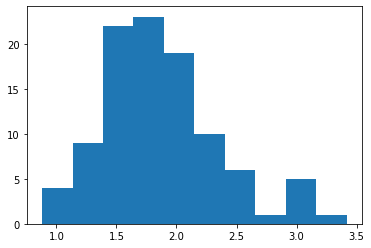

In [55]:
plt.hist(samples.numpy()[:, 1])
plt.show()